5216 16 624
['NORMAL', 'PNEUMONIA'] ['NORMAL', 'PNEUMONIA'] ['NORMAL', 'PNEUMONIA']


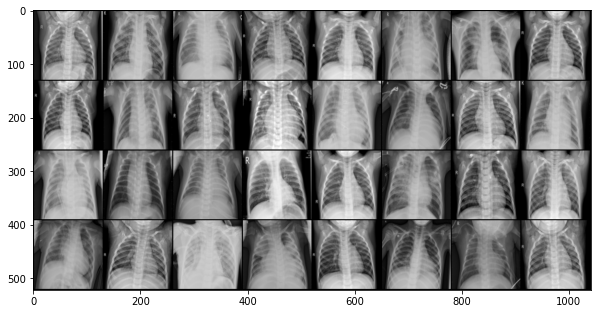

In [80]:
import os
from time import time, strftime, gmtime
import numpy as np 
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt

PATH ='./'

batchSize = 32
imgSize = 128

train_set = datasets.ImageFolder(os.path.join(PATH, 'train'), transforms.Compose([
            transforms.Resize(size = (imgSize, imgSize)),
            transforms.ToTensor()
]))

val_set = datasets.ImageFolder(os.path.join(PATH, 'val'), transforms.Compose([
            transforms.Resize(size = (imgSize, imgSize)),
            transforms.ToTensor()
]))

test_set = datasets.ImageFolder(os.path.join(PATH, 'test'), transforms.Compose([
            transforms.Resize(size = (imgSize, imgSize)),
            transforms.ToTensor()
]))
print(len(train_set), len(val_set), len(test_set))

train_loader = torch.utils.data.DataLoader(train_set, batch_size = batchSize, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size = batchSize, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size = batchSize, shuffle=True)

print(train_set.classes, val_set.classes, test_set.classes)

# plot images
plt.figure(figsize=[10, 10])
plt.imshow(torchvision.utils.make_grid(next(iter(train_loader))[0], nrow=8).permute(1,2,0))



In [81]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# device = torch.device("cpu")
print('Using device:', device)

torch.manual_seed(1337)

model = nn.Sequential(
    
    nn.Conv2d(3, 32, kernel_size=3),
    nn.ReLU(),
#     nn.MaxPool2d(kernel_size=3),
    nn.Dropout2d(p=0.2),
    nn.BatchNorm2d(32),
    
    nn.Conv2d(32, 64, kernel_size=3),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=3),
    nn.Dropout2d(p=0.2),
    nn.BatchNorm2d(64),
    
    nn.Conv2d(64, 128, kernel_size=3),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=3),
    nn.Dropout2d(p=0.2),
    nn.BatchNorm2d(128),
    
    nn.Conv2d(128, 256, kernel_size=3),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=3),
    nn.Dropout2d(p=0.2),
    nn.BatchNorm2d(256),
    
    nn.Conv2d(256, 1, kernel_size=3),
    nn.ReLU(),

    nn.Sigmoid(),
    # clean up output for optmizer
    nn.Flatten()
)
    
optimizer = torch.optim.RMSprop(model.parameters())
model.to(device)
print(model)

Using device: cuda
Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (1): ReLU()
  (2): Dropout2d(p=0.2, inplace=False)
  (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (5): ReLU()
  (6): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (7): Dropout2d(p=0.2, inplace=False)
  (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (10): ReLU()
  (11): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (12): Dropout2d(p=0.2, inplace=False)
  (13): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (15): ReLU()
  (16): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (17): Dropout2d(p=0.2, inplace=False)
  (18): Bat

In [82]:
# free memory
if device == 'cuda': 
    torch.cuda.empty_cache()

start_train = time()
for epoch in range(3):
    # Training
    i = 0
    start_epoch = time()
    for tx, ty in train_loader:
        tx, ty = tx.to(device), ty.to(device)
        # if not transposed and flatted the loss function input will fail
        model.train()
        ypred_sigmoid = torch.flatten(torch.transpose(model(tx), 0,1))
    
        # training
        loss = F.binary_cross_entropy(ypred_sigmoid, ty.float())
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        i+=len(ty)
        if i < len(train_set):
            print(f"Training of Epoch {epoch} - Loss:{loss} - Processed {i} of {len(train_set)} - Duration {strftime('%H:%M:%S',gmtime(time() - start_epoch))}     ", end="\r")
        else:
            print(f"Training of Epoch {epoch} - Loss:{loss} - Finished - Duration {strftime('%H:%M:%S',gmtime(time() - start_epoch))}                         ")
    # Validation
    model.eval()
    with torch.no_grad():
        total_val = 0.0
        correct_val = 0.0
        for vx, vy in val_loader:
            vx, vy = vx.to(device), vy.to(device)
            ypred_val = (torch.flatten(torch.transpose(model(vx), 0,1)) > 0.5).float()
            total_val += len(vy)
            correct_val += (ypred_val == vy).sum().item()
        accuracy_val = correct_val / total_val
        print(f"Epoch {epoch} - Accuracy:{accuracy_val*100}%  - Duration {strftime('%H:%M:%S',gmtime(time() - start_epoch))}")
# Testing
print(f"Testing Model - Duration Training {strftime('%H:%M:%S',gmtime(time() - start_train))}")
model.eval()
with torch.no_grad():
    total_test = 0.0
    correct_test = 0.0
    for tsx, tsy in val_loader:
        tsx, tsy = tsx.to(device), tsy.to(device)
        ypred_test = (torch.flatten(torch.transpose(model(tsx), 0,1)) > 0.5).float()
        total_test += len(tsy)
        correct_test += (ypred_test == tsy).sum().item()
    accuracy_test = correct_test / total_test
    print(f"Final accuracy:{accuracy_test*100}% - Duration {strftime('%H:%M:%S',gmtime(time() - start_train))}")

Training of Epoch 0 - Loss:0.6931471824645996 - Finished - Duration 00:01:24                         
Epoch 0 - Accuracy:50.0%  - Duration 00:01:24
Training of Epoch 1 - Loss:0.6931471824645996 - Finished - Duration 00:01:15                         
Epoch 1 - Accuracy:50.0%  - Duration 00:01:16
Training of Epoch 2 - Loss:0.6931471824645996 - Finished - Duration 00:01:17                         
Epoch 2 - Accuracy:50.0%  - Duration 00:01:18
Testing Model - Duration Training 00:03:59
Final accuracy:50.0% - Duration 00:03:59
